In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Kaggle's Cats vs Dogs**
Download our cats vs dogs dataset. Should talk around 15-20 seconds.
Source - https://www.kaggle.com/c/dogs-vs-cats/data

In [2]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:14<00:00, 57.2MB/s]


In [6]:
# Set directory paths for our files
train_dir = './train'
test_dir = './test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)
print(train_files[:5])

['dog.8303.jpg', 'dog.205.jpg', 'dog.1092.jpg', 'cat.5831.jpg', 'cat.9883.jpg']


In [4]:
print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

Number of images in ./train is 25000
Number of images in ./test1 is 12500


In [5]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

./train/dog.8303.jpg


#### **Create our transformations**

In [7]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

## **Create a Dataset class that stores our dataset information (paths, labels and transformations**

This object can then be utilzied by torch functions such as `torch.utils.data.random_split`

https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [8]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [9]:
# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

### **Using our dataset Object**

In [10]:
# Getting a data entry
train.__getitem__(0)

(tensor([[[0.5255, 0.5176, 0.5765,  ..., 0.9529, 0.9569, 0.9569],
          [0.5059, 0.4824, 0.4353,  ..., 0.9608, 0.9569, 0.9569],
          [0.4275, 0.4353, 0.3961,  ..., 0.9529, 0.9569, 0.9569],
          ...,
          [0.0784, 0.1020, 0.2627,  ..., 0.8824, 0.9373, 0.9490],
          [0.0667, 0.1176, 0.2627,  ..., 0.8039, 0.9176, 0.9412],
          [0.1020, 0.1490, 0.2824,  ..., 0.7529, 0.8824, 0.9294]],
 
         [[0.5725, 0.5686, 0.5882,  ..., 0.9569, 0.9569, 0.9569],
          [0.5529, 0.5216, 0.4784,  ..., 0.9529, 0.9569, 0.9569],
          [0.4706, 0.4784, 0.4667,  ..., 0.9569, 0.9569, 0.9529],
          ...,
          [0.0784, 0.1020, 0.2706,  ..., 0.7922, 0.8706, 0.8784],
          [0.0667, 0.1373, 0.3020,  ..., 0.6980, 0.8314, 0.8745],
          [0.0902, 0.1490, 0.2784,  ..., 0.6353, 0.7843, 0.8588]],
 
         [[0.3804, 0.3804, 0.4235,  ..., 0.9529, 0.9569, 0.9569],
          [0.3765, 0.3804, 0.3373,  ..., 0.9451, 0.9569, 0.9569],
          [0.3529, 0.3647, 0.3569,  ...,

In [11]:
# Getting the shape of a single image
print(val.__getitem__(0)[0].shape)
print(train.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


## **Using our dataset object to create our train, validation split**

In [13]:
train, val = torch.utils.data.random_split(train,[20000,5000])

In [14]:
# Getting a size of our
print(len(train))
print(len(val))

20000
5000


In [15]:
# Let's create an array of our labels
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val)) ]

<Axes: ylabel='count'>

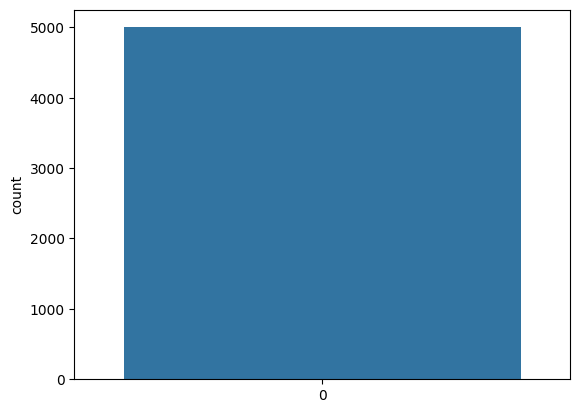

In [18]:
import seaborn as sns

sns.countplot(val_set_class_count)

## **Dataloaders - let's create our iterable over a dataset**

In [19]:
train_dataset = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

### **Use it to get some sample images**

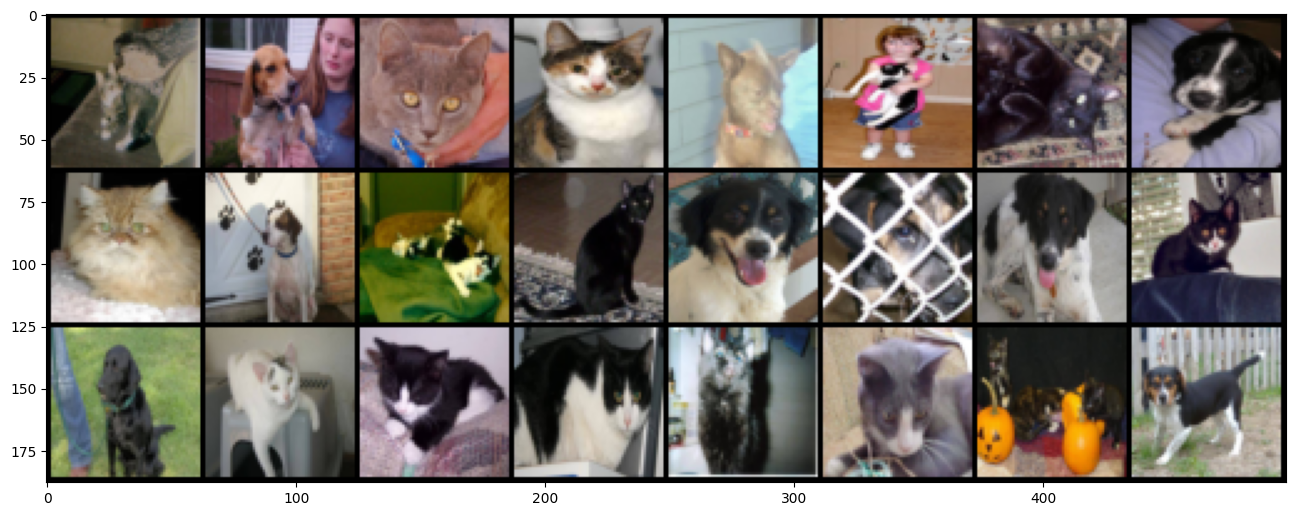

In [21]:
samples, labels = next(iter(train_dataset))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

**Now we build our Model**

We will use the ```nn.Sequential``` method to construct our model. Alernatively we can use the functional module, however this is simpler and more similar to styles you'll work with in Keras.

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            )

        self.conv2 =   nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv3 =   nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*5*5,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU()
        )

        self.fc2 = nn.Sequential(
        nn.Linear(128,2),
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

### **Using TorchSummary to display a Keras style summary output**

`summary(your_model, input_size=(channels, H, W))`

In [23]:
model = CNN()
model.cuda()
summary(model,(3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 256]         409,856
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

### **Defining a Loss Function and Optimizer**

We need to define what type of loss we'll be using and what method will be using to update the gradients.
1. We use Cross Entropy Loss
2. We use the Adam Optimization Descent Algorithm - we also specify a learn rate (LR) of 0.0005.
3. Set our epochs to 50

In [24]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 10

## **Train our Model**

**We use TQDM to perform a keras style training**


In [25]:
type(train_dataset)

torch.utils.data.dataloader.DataLoader

In [26]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Set our unit for tqdm and number of iterations i.e. len(train_dataset) no need for len as train_dataset is an iteratable
    # tepoch becomes
    with tqdm(train_dataset, unit="batch") as tepoch:
        # our progress bar labels
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for data,label in tepoch:
            data,label = data.to(device), label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimiser.step()

            train_running_loss += loss.item() * data.size(0)

            _, pred = torch.max(output.data, 1)

            # Keep track of how many images have been foward propagated
            total += label.size(0)
            # Keep track of how many were predicted to be correct
            correct += (pred == label).sum().item()

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Get our validation accuracy and loss scores
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # We don't need gradients for validation, so wrap in  no_grad to save memory
        with torch.no_grad():
            for val_data, val_label in val_dataset:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                # Calacuate the running loss by multiplying loss value by batch size
                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)
                total += val_label.size(0)
                correct += (pred == val_label).sum().item()

            val_accuracy.append(correct/total)
            # Calcuate loss per epoch by dividing runing loss by number of items in validation set
            val_loss.append(val_running_loss/len(val_dataset))

            #print(val_running_loss)
            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')

<ipython-input-26-ed1d14d94d43>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit="batch") as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy = 0.5722
Epoch 1 Training Loss = 21.58798627319336
Epoch 1 Validation Accuracy = 0.655
Epoch 1 Validation Loss = 19.875528499578973


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.67995
Epoch 2 Training Loss = 19.365969564819334
Epoch 2 Validation Accuracy = 0.715
Epoch 2 Validation Loss = 18.440222724987443


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.7258
Epoch 3 Training Loss = 18.199515582275392
Epoch 3 Validation Accuracy = 0.7344
Epoch 3 Validation Loss = 17.68073418185969


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.75765
Epoch 4 Training Loss = 17.31089974975586
Epoch 4 Validation Accuracy = 0.7622
Epoch 4 Validation Loss = 17.055947094206598


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.7765
Epoch 5 Training Loss = 16.752557102966307
Epoch 5 Validation Accuracy = 0.774
Epoch 5 Validation Loss = 16.67242666110871


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.7933
Epoch 6 Training Loss = 16.240712629699708
Epoch 6 Validation Accuracy = 0.7778
Epoch 6 Validation Loss = 16.66094436159559


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.8002
Epoch 7 Training Loss = 16.056022007751466
Epoch 7 Validation Accuracy = 0.786
Epoch 7 Validation Loss = 16.465080230858675


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.81515
Epoch 8 Training Loss = 15.681666757202148
Epoch 8 Validation Accuracy = 0.7776
Epoch 8 Validation Loss = 16.5615703740697


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.82825
Epoch 9 Training Loss = 15.280153866577148
Epoch 9 Validation Accuracy = 0.788
Epoch 9 Validation Loss = 16.322029368892597


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.839
Epoch 10 Training Loss = 14.967246592712403
Epoch 10 Validation Accuracy = 0.7872
Epoch 10 Validation Loss = 16.315966390500403


In [27]:
train_loss

[21.58798627319336,
 19.365969564819334,
 18.199515582275392,
 17.31089974975586,
 16.752557102966307,
 16.240712629699708,
 16.056022007751466,
 15.681666757202148,
 15.280153866577148,
 14.967246592712403]

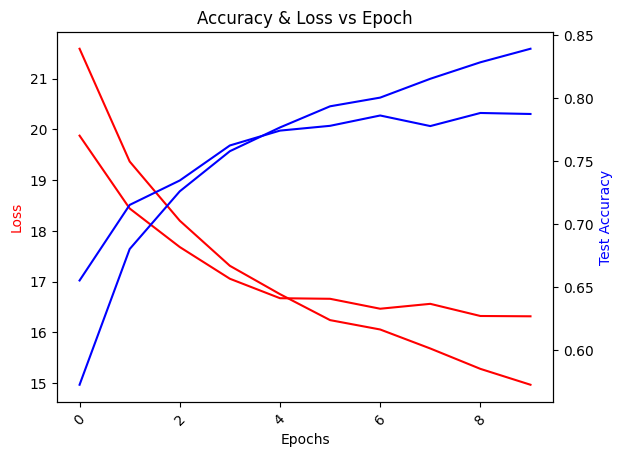

In [29]:
epoch_log = [*range(epochs)]

# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, train_loss, 'r-')
ax2.plot(epoch_log, train_accuracy, 'b-')

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, val_loss, 'r-')
ax2.plot(epoch_log, val_accuracy, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [30]:
PATH = './cats_vs_dogs_10_epochs.pth'
torch.save(model.state_dict(), PATH)

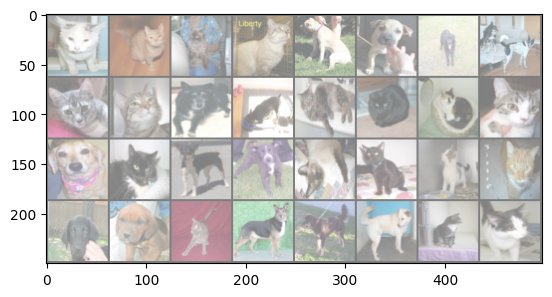

GroundTruth:  00001111001100001011000011011100


In [32]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Loading one mini-batch
dataiter = iter(val_dataset)
images, labels = next(dataiter)

# Display images using torchvision's utils.make_grid()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',''.join('%1s' % labels[j].numpy() for j in range(32)))

In [33]:
# Create an instance of the model and move it (memory and operations) to the CUDA device.
model = CNN()
model.to(device)

# Load weights from the specified path
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

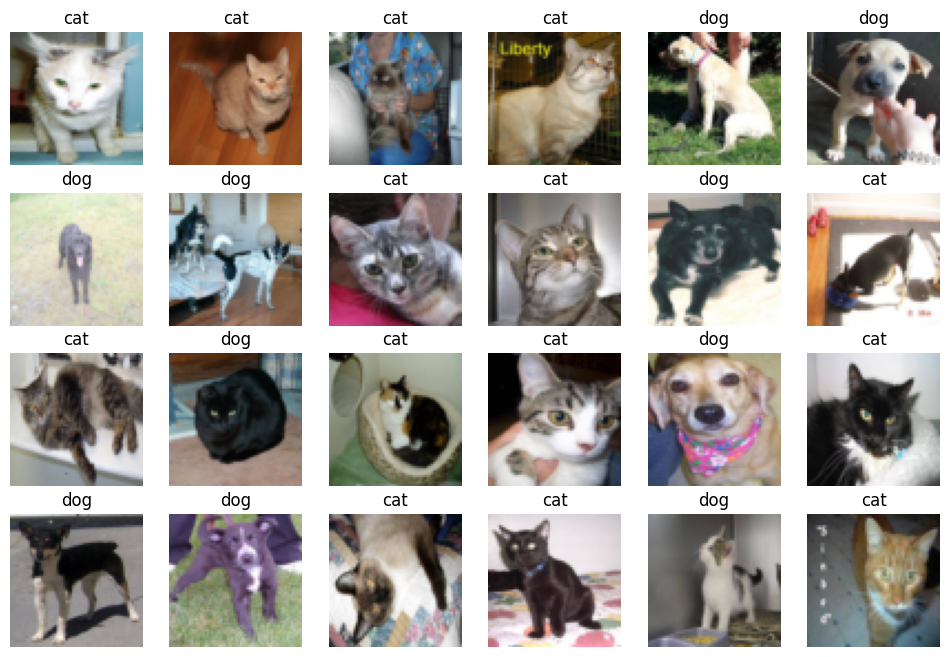

In [34]:
samples, _ = next(iter(val_dataset))
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))